Completed: 48 steps
Run time: 0:00:00.049207
Simulation finished


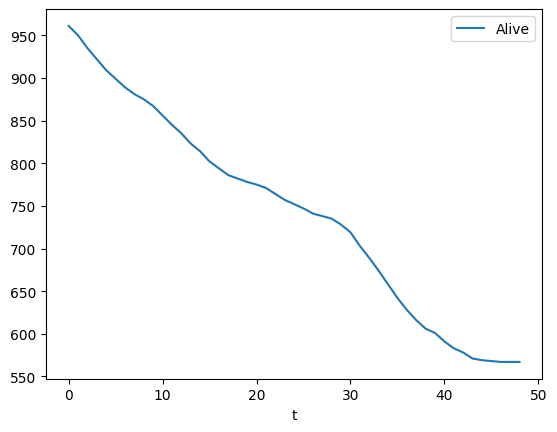

In [10]:
# Model design
import agentpy as ap

# Visualization
import matplotlib.pyplot as plt

class Trees(ap.Agent):

    internal_states = {
        'alive': 0,
        'burning': 1,
        'burned': 2
    }

    def setup(self):
        self.state = self.internal_states['alive']

    def see(self):
        neighbors = self.model.forest.neighbors(self)
        return any(neighbor.state == self.internal_states['burning'] for neighbor in neighbors)

    def next(self):
        if self.state == self.internal_states['alive']:
            neighbors = self.model.forest.neighbors(self)
            for neighbor in neighbors:
                if neighbor.state == self.internal_states['burning']:
                    self.state = self.internal_states['burning']
                    return

    def action(self):
        if self.state == self.internal_states['burning']:
            self.state = self.internal_states['burned']

class ForestModel(ap.Model):

    def setup(self):
        # Create agents (trees)
        n_trees = int(self.p['Tree density'] * (self.p.size**2))
        trees = self.agents = ap.AgentList(self, n_trees, Trees)

        # Create grid (forest)
        self.forest = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.forest.add_agents(trees, random=True, empty=True)

        # Start a fire from the left side of the grid
        unfortunate_trees = self.forest.agents[0:self.p.size, 0:2]
        for tree in unfortunate_trees:
            tree.state = 1

    def step(self):
        # Select burning trees
        burning_trees = self.agents.select(self.agents.state == 1)

        # Spread fire
        for tree in burning_trees:
            for neighbor in self.forest.neighbors(tree):
                if neighbor.state == 0:
                    neighbor.state = 1  # Neighbor starts burning
            tree.state = 2  # Tree burns out

        # Stop simulation if no fire is left
        if len(burning_trees) == 0:
            self.stop()
            
    def update(self):
        self.record('Alive', utility(self.agents))

    def end(self):
        # Document a measure at the end of the simulation
        burned_trees = len(self.agents.select(self.agents.state == 2))
        self.report('Percentage of burned trees',
                    burned_trees / len(self.agents))
        

def utility(agents):
    """ Count the number of trees who are 'alive' in state """
    return sum(agent.state == Trees.internal_states['alive'] for agent in agents)

# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.forest.attr_grid('state')
    color_dict = {0: '#7FC97F', 1: '#d62c2c', 2: '#e5e5e5', None: '#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a forest fire\n"
                 f"Time-step: {model.t}, Trees left: "
                 f"{len(model.agents.select(model.agents.state == 0))}")

# Define parameters

parameters = {
    'Tree density': 0.4,  # Percentage of grid covered by trees
    'size': 50,  # Height and length of the grid
    'steps': 100,
}

model = ForestModel(parameters)

results = model.run()

data = results.variables.ForestModel
ax = data.plot()
plt.show()